# Load libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tslearn.clustering import silhouette_score, TimeSeriesKMeans
import pickle
import pywt
from tslearn.preprocessing import TimeSeriesScalerMinMax

# Load dataset

In [6]:
data = pd.read_csv("../../data/Final_Energy_dataset.csv")
data['Date'] = pd.to_datetime(data['Date'])

# Prepare test dataset
data_test = data[((data['Date'].dt.month > 6) & (data['Date'].dt.year == 2011)) 
            | ((data['Date'].dt.month <= 6) & (data['Date'].dt.year == 2012))]
load_test = data_test[["load_1","load_2","load_3","load_4","load_5","load_6","load_7","load_8","load_9","load_10",
                        "load_11","load_12","load_13","load_14","load_15","load_16","load_17","load_18","load_19","load_20",
                        "load_21","load_22","load_23","load_24","load_25","load_26","load_27","load_28","load_29","load_30"]]
pv_test = data_test[["pv_1","pv_2","pv_3","pv_4","pv_5","pv_6","pv_7","pv_8","pv_9","pv_10",
                        "pv_11","pv_12","pv_13","pv_14","pv_15","pv_16","pv_17","pv_18","pv_19","pv_20",
                        "pv_21","pv_22","pv_23","pv_24","pv_25","pv_26","pv_27","pv_28","pv_29","pv_30"]]
test_prosumption = pd.DataFrame()
column_mapping = {f"load_{i}": f"pv_{i}" for i in range(1, 31)}
rename_mapping = {f"load_{i}": f"prosumption_{i}" for i in range(1, 31)}
for col1, col2 in column_mapping.items():
    test_prosumption[col1] = load_test[col1] - pv_test[col2]
test_prosumption.rename(columns=rename_mapping, inplace=True)
test_prosumption = test_prosumption.reset_index(drop=True).transpose()

# Cluster #1 - First day of each month 

In [7]:
cluster_data = data[((data['Date'].dt.day == 1) & (data['Date'].dt.month > 6) & (data['Date'].dt.year == 2010)) 
            | ((data['Date'].dt.day == 1) & (data['Date'].dt.month <= 6) & (data['Date'].dt.year == 2011))]
load_cluster = cluster_data[["load_1","load_2","load_3","load_4","load_5","load_6","load_7","load_8","load_9","load_10",
                        "load_11","load_12","load_13","load_14","load_15","load_16","load_17","load_18","load_19","load_20",
                        "load_21","load_22","load_23","load_24","load_25","load_26","load_27","load_28","load_29","load_30"]]
pv_cluster = cluster_data[["pv_1","pv_2","pv_3","pv_4","pv_5","pv_6","pv_7","pv_8","pv_9","pv_10",
                    "pv_11","pv_12","pv_13","pv_14","pv_15","pv_16","pv_17","pv_18","pv_19","pv_20",
                    "pv_21","pv_22","pv_23","pv_24","pv_25","pv_26","pv_27","pv_28","pv_29","pv_30"]]
cluster_prosumption = pd.DataFrame()
for col1, col2 in column_mapping.items():
    cluster_prosumption[col1] = load_cluster[col1] - pv_cluster[col2]
cluster_prosumption.rename(columns=rename_mapping, inplace=True)
cluster_prosumption = cluster_prosumption.reset_index(drop=True).transpose()
cluster_prosumption = TimeSeriesScalerMinMax().fit_transform(cluster_prosumption.values.reshape((30,575,1)))

## K-means DTW

In [5]:
for i in range(2,30):
    print(f"Clustersize: {i}")
    kmeans_cluster = TimeSeriesKMeans(n_clusters=i, metric="dtw", n_init=3, n_jobs=-1)
    kmeans_cluster.fit_predict(cluster_prosumption)
    pickle.dump(kmeans_cluster, open(f"clustering/kmeans_fst_days_{i}.pkl", "wb"))

Clustersize: 2
Clustersize: 3
Clustersize: 4
Clustersize: 5
Clustersize: 6
Clustersize: 7
Clustersize: 8
Clustersize: 9
Clustersize: 10
Clustersize: 11
Clustersize: 12
Clustersize: 13
Clustersize: 14
Clustersize: 15
Clustersize: 16
Clustersize: 17
Clustersize: 18
Clustersize: 19
Clustersize: 20
Clustersize: 21
Clustersize: 22
Clustersize: 23
Clustersize: 24
Clustersize: 25
Clustersize: 26
Clustersize: 27
Clustersize: 28
Clustersize: 29


## DWT K-means Euclidean

In [9]:
cluster_coeffs = np.empty((30, 576, 1))
for i in range(0,30):
    ts = cluster_prosumption[i].flatten() 
    low, high = pywt.dwt(ts, wavelet='db1')
    cluster_coeffs[i] = np.concatenate((low.reshape(low.shape[0],1), high.reshape(high.shape[0],1)))
for i in range(2,30):
    print(f"Clustersize: {i}")
    kmeans_cluster = TimeSeriesKMeans(n_clusters=i, metric="euclidean", n_init=3, n_jobs=-1)
    kmeans_cluster.fit_predict(cluster_coeffs)
    pickle.dump(kmeans_cluster, open(f"clustering/kmeans_fst_days_coeffs_{i}.pkl", "wb"))

Clustersize: 2
Clustersize: 3
Clustersize: 4
Clustersize: 5
Clustersize: 6
Clustersize: 7
Clustersize: 8
Clustersize: 9
Clustersize: 10
Clustersize: 11
Clustersize: 12
Clustersize: 13
Clustersize: 14
Clustersize: 15
Clustersize: 16
Clustersize: 17
Clustersize: 18
Clustersize: 19
Clustersize: 20
Clustersize: 21
Clustersize: 22
Clustersize: 23
Clustersize: 24
Clustersize: 25
Clustersize: 26
Clustersize: 27
Clustersize: 28
Clustersize: 29


In [14]:
silhouette_scores = {}
for i in range(2,30):
    kmeans_cluster = pickle.load(open(f"clustering/kmeans_fst_days_{i}.pkl", "rb"))
    silhouette_scores[i] = silhouette_score(cluster_prosumption, kmeans_cluster.labels_, metric='dtw', n_jobs=-1)
results = pd.DataFrame(index=silhouette_scores.keys())
results['fst_day'] = silhouette_scores.values()

silhouette_scores = {}
for i in range(2,30):
    kmeans_cluster = pickle.load(open(f"clustering/kmeans_fst_days_coeffs_{i}.pkl", "rb"))
    silhouette_scores[i] = silhouette_score(cluster_prosumption, kmeans_cluster.labels_, metric='euclidean', n_jobs=-1)
results['fst_day_dwt'] = silhouette_scores.values()

,fst_day,fst_day_dwt
2,0.264845,0.282119
3,0.135974,0.111236
4,0.096199,0.089984
5,0.093592,0.056321
6,0.083246,0.073366
7,0.054042,0.036140
8,0.054108,0.065622
9,0.092803,0.045366
10,0.085894,0.057868
11,0.077988,0.038978


# Cluster #2 - Mean day of week -> timeslot

In [15]:
cluster_data = data[(data['Date'].dt.year == 2010) | (data['Date'].dt.month <= 6) & (data['Date'].dt.year == 2011)]
load_cluster = cluster_data[["load_1","load_2","load_3","load_4","load_5","load_6","load_7","load_8","load_9","load_10",
                    "load_11","load_12","load_13","load_14","load_15","load_16","load_17","load_18","load_19","load_20",
                    "load_21","load_22","load_23","load_24","load_25","load_26","load_27","load_28","load_29","load_30"]]
pv_cluster = cluster_data[["pv_1","pv_2","pv_3","pv_4","pv_5","pv_6","pv_7","pv_8","pv_9","pv_10",
                    "pv_11","pv_12","pv_13","pv_14","pv_15","pv_16","pv_17","pv_18","pv_19","pv_20",
                    "pv_21","pv_22","pv_23","pv_24","pv_25","pv_26","pv_27","pv_28","pv_29","pv_30"]]
cluster_prosumption = pd.DataFrame()
cluster_prosumption.insert(0, 'Date', cluster_data['Date'], True)
for col1, col2 in column_mapping.items():
    cluster_prosumption[col1] = load_cluster[col1] - pv_cluster[col2]
cluster_prosumption.rename(columns=rename_mapping, inplace=True)
cluster_prosumption.insert(0, 'dow', cluster_data['Date'].dt.dayofweek, True)
cluster_prosumption.insert(1, 'timeslot', cluster_data['Date'].dt.time, True)
cluster_prosumption.drop(columns=['Date'], inplace=True)
grouped_prosumption = cluster_prosumption.groupby(['dow','timeslot']).mean()
grouped_prosumption = grouped_prosumption.reset_index(drop=True).transpose()
grouped_prosumption = TimeSeriesScalerMinMax().fit_transform(grouped_prosumption.values.reshape((30,336,1)))

## K-means DTW

In [8]:
for i in range(2,30):
    print(f"Clustersize: {i}")
    kmeans_cluster = TimeSeriesKMeans(n_clusters=i, metric="dtw", n_init=3, n_jobs=-1)
    kmeans_cluster.fit_predict(grouped_prosumption)
    pickle.dump(kmeans_cluster, open(f"clustering/kmeans_mean_year_{i}.pkl", "wb"))

Clustersize: 2
Clustersize: 3
Clustersize: 4
Clustersize: 5
Clustersize: 6
Clustersize: 7
Clustersize: 8
Clustersize: 9
Clustersize: 10
Clustersize: 11
Clustersize: 12
Clustersize: 13
Clustersize: 14
Clustersize: 15
Clustersize: 16
Clustersize: 17
Clustersize: 18
Clustersize: 19
Clustersize: 20
Clustersize: 21
Clustersize: 22
Clustersize: 23
Clustersize: 24
Clustersize: 25
Clustersize: 26
Clustersize: 27
Clustersize: 28
Clustersize: 29


## DWT K-means Euclidean

In [18]:
cluster_coeffs = np.empty((30, 336, 1))
for i in range(0,30):
    ts = grouped_prosumption[i].flatten() 
    low, high = pywt.dwt(ts, wavelet='db1')
    cluster_coeffs[i] = np.concatenate((low.reshape(low.shape[0],1), high.reshape(high.shape[0],1)))
for i in range(2,30):
    print(f"Clustersize: {i}")
    kmeans_cluster = TimeSeriesKMeans(n_clusters=i, metric="euclidean", n_init=3, n_jobs=-1)
    kmeans_cluster.fit_predict(cluster_coeffs)
    pickle.dump(kmeans_cluster, open(f"clustering/kmeans_mean_year_coeffs_{i}.pkl", "wb"))

Clustersize: 2
Clustersize: 3
Clustersize: 4
Clustersize: 5
Clustersize: 6
Clustersize: 7
Clustersize: 8
Clustersize: 9
Clustersize: 10
Clustersize: 11
Clustersize: 12
Clustersize: 13
Clustersize: 14
Clustersize: 15
Clustersize: 16
Clustersize: 17
Clustersize: 18
Clustersize: 19
Clustersize: 20
Clustersize: 21
Clustersize: 22
Clustersize: 23
Clustersize: 24
Clustersize: 25
Clustersize: 26
Clustersize: 27
Clustersize: 28
Clustersize: 29


In [19]:
silhouette_scores = {}
for i in range(2,30):
    kmeans_cluster = pickle.load(open(f"clustering/kmeans_mean_year_{i}.pkl", "rb"))
    silhouette_scores[i] = silhouette_score(grouped_prosumption, kmeans_cluster.labels_, metric='dtw', n_jobs=-1)
results['mean_year'] = silhouette_scores.values()

silhouette_scores = {}
for i in range(2,30):
    kmeans_cluster = pickle.load(open(f"clustering/kmeans_mean_year_coeffs_{i}.pkl", "rb"))
    silhouette_scores[i] = silhouette_score(grouped_prosumption, kmeans_cluster.labels_, metric='euclidean', n_jobs=-1)
results['mean_year_dwt'] = silhouette_scores.values()

# Cluster #3 - Mean timeslot

In [20]:
cluster_data = data[(data['Date'].dt.year == 2010) | (data['Date'].dt.month <= 6) & (data['Date'].dt.year == 2011)]
load_cluster = cluster_data[["load_1","load_2","load_3","load_4","load_5","load_6","load_7","load_8","load_9","load_10",
                    "load_11","load_12","load_13","load_14","load_15","load_16","load_17","load_18","load_19","load_20",
                    "load_21","load_22","load_23","load_24","load_25","load_26","load_27","load_28","load_29","load_30"]]
pv_cluster = cluster_data[["pv_1","pv_2","pv_3","pv_4","pv_5","pv_6","pv_7","pv_8","pv_9","pv_10",
                    "pv_11","pv_12","pv_13","pv_14","pv_15","pv_16","pv_17","pv_18","pv_19","pv_20",
                    "pv_21","pv_22","pv_23","pv_24","pv_25","pv_26","pv_27","pv_28","pv_29","pv_30"]]
cluster_prosumption = pd.DataFrame()
cluster_prosumption.insert(0, 'Date', cluster_data['Date'], True)
for col1, col2 in column_mapping.items():
    cluster_prosumption[col1] = load_cluster[col1] - pv_cluster[col2]
cluster_prosumption.rename(columns=rename_mapping, inplace=True)
cluster_prosumption.insert(0, 'timeslot', cluster_data['Date'].dt.time, True)
cluster_prosumption.drop(columns=['Date'], inplace=True)
grouped_prosumption = cluster_prosumption.groupby(['timeslot']).mean()
grouped_prosumption = grouped_prosumption.reset_index(drop=True).transpose()
grouped_prosumption = TimeSeriesScalerMinMax().fit_transform(grouped_prosumption.values.reshape((30,48,1)))

## K-means DTW

In [14]:
for i in range(2,30):
    print(f"Clustersize: {i}")
    kmeans_cluster = TimeSeriesKMeans(n_clusters=i, metric="dtw", n_init=3, n_jobs=-1)
    kmeans_cluster.fit_predict(grouped_prosumption)
    pickle.dump(kmeans_cluster, open(f"clustering/kmeans_mean_timeslot_{i}.pkl", "wb"))

Clustersize: 2
Clustersize: 3
Clustersize: 4
Clustersize: 5
Clustersize: 6
Clustersize: 7
Clustersize: 8
Clustersize: 9
Clustersize: 10
Clustersize: 11
Clustersize: 12
Clustersize: 13
Clustersize: 14
Clustersize: 15
Clustersize: 16
Clustersize: 17
Clustersize: 18
Clustersize: 19
Clustersize: 20
Clustersize: 21
Clustersize: 22
Clustersize: 23
Clustersize: 24
Clustersize: 25
Clustersize: 26
Clustersize: 27
Clustersize: 28
Clustersize: 29


## DWT K-means Euclidean

In [24]:
cluster_coeffs = np.empty((30, 48, 1))
for i in range(0,30):
    ts = grouped_prosumption[i].flatten() 
    low, high = pywt.dwt(ts, wavelet='db1')
    cluster_coeffs[i] = np.concatenate((low.reshape(low.shape[0],1), high.reshape(high.shape[0],1)))
for i in range(2,30):
    print(f"Clustersize: {i}")
    kmeans_cluster = TimeSeriesKMeans(n_clusters=i, metric="euclidean", n_init=3, n_jobs=-1)
    kmeans_cluster.fit_predict(cluster_coeffs)
    pickle.dump(kmeans_cluster, open(f"clustering/kmeans_mean_timeslot_coeffs_{i}.pkl", "wb"))

Clustersize: 2
Clustersize: 3
Clustersize: 4
Clustersize: 5
Clustersize: 6
Clustersize: 7
Clustersize: 8
Clustersize: 9
Clustersize: 10
Clustersize: 11
Clustersize: 12
Clustersize: 13
Clustersize: 14
Clustersize: 15
Clustersize: 16
Clustersize: 17
Clustersize: 18
Clustersize: 19
Clustersize: 20
Clustersize: 21
Clustersize: 22
Clustersize: 23
Clustersize: 24
Clustersize: 25
Clustersize: 26
Clustersize: 27
Clustersize: 28
Clustersize: 29


In [25]:
silhouette_scores = {}
for i in range(2,30):
    kmeans_cluster = pickle.load(open(f"clustering/kmeans_mean_timeslot_{i}.pkl", "rb"))
    silhouette_scores[i] = silhouette_score(grouped_prosumption, kmeans_cluster.labels_, metric='dtw', n_jobs=-1)
results['mean_timeslot'] = silhouette_scores.values()

silhouette_scores = {}
for i in range(2,30):
    kmeans_cluster = pickle.load(open(f"clustering/kmeans_mean_timeslot_coeffs_{i}.pkl", "rb"))
    silhouette_scores[i] = silhouette_score(grouped_prosumption, kmeans_cluster.labels_, metric='euclidean', n_jobs=-1)
results['mean_timeslot_dwt'] = silhouette_scores.values()

# Cluster #4 - Mean month -> timeslot

In [26]:
cluster_data = data[(data['Date'].dt.year == 2010) | (data['Date'].dt.month <= 6) & (data['Date'].dt.year == 2011)]
load_cluster = cluster_data[["load_1","load_2","load_3","load_4","load_5","load_6","load_7","load_8","load_9","load_10",
                    "load_11","load_12","load_13","load_14","load_15","load_16","load_17","load_18","load_19","load_20",
                    "load_21","load_22","load_23","load_24","load_25","load_26","load_27","load_28","load_29","load_30"]]
pv_cluster = cluster_data[["pv_1","pv_2","pv_3","pv_4","pv_5","pv_6","pv_7","pv_8","pv_9","pv_10",
                    "pv_11","pv_12","pv_13","pv_14","pv_15","pv_16","pv_17","pv_18","pv_19","pv_20",
                    "pv_21","pv_22","pv_23","pv_24","pv_25","pv_26","pv_27","pv_28","pv_29","pv_30"]]
cluster_prosumption = pd.DataFrame()
cluster_prosumption.insert(0, 'Date', cluster_data['Date'], True)
for col1, col2 in column_mapping.items():
    cluster_prosumption[col1] = load_cluster[col1] - pv_cluster[col2]
cluster_prosumption.rename(columns=rename_mapping, inplace=True)
cluster_prosumption.insert(0, 'month', cluster_data['Date'].dt.month, True)
cluster_prosumption.insert(1, 'timeslot', cluster_data['Date'].dt.time, True)
cluster_prosumption.drop(columns=['Date'], inplace=True)
grouped_prosumption = cluster_prosumption.groupby(['month', 'timeslot']).mean()
grouped_prosumption = grouped_prosumption.reset_index(drop=True).transpose()
grouped_prosumption = TimeSeriesScalerMinMax().fit_transform(grouped_prosumption.values.reshape((30,48*12,1)))

In [20]:
for i in range(2,30):
    print(f"Clustersize: {i}")
    kmeans_cluster = TimeSeriesKMeans(n_clusters=i, metric="dtw", n_init=3, n_jobs=-1)
    kmeans_cluster.fit_predict(grouped_prosumption)
    pickle.dump(kmeans_cluster, open(f"clustering/kmeans_mean_month_{i}.pkl", "wb"))

Clustersize: 2
Clustersize: 3
Clustersize: 4
Clustersize: 5
Clustersize: 6
Clustersize: 7
Clustersize: 8
Clustersize: 9
Clustersize: 10
Clustersize: 11
Clustersize: 12
Clustersize: 13
Clustersize: 14
Clustersize: 15
Clustersize: 16
Clustersize: 17
Clustersize: 18
Clustersize: 19
Clustersize: 20
Clustersize: 21
Clustersize: 22
Clustersize: 23
Clustersize: 24
Clustersize: 25
Clustersize: 26
Clustersize: 27
Clustersize: 28
Clustersize: 29


In [27]:
cluster_coeffs = np.empty((30, 48*12, 1))
for i in range(0,30):
    ts = grouped_prosumption[i].flatten() 
    low, high = pywt.dwt(ts, wavelet='db1')
    cluster_coeffs[i] = np.concatenate((low.reshape(low.shape[0],1), high.reshape(high.shape[0],1)))
for i in range(2,30):
    print(f"Clustersize: {i}")
    kmeans_cluster = TimeSeriesKMeans(n_clusters=i, metric="euclidean", n_init=3, n_jobs=-1)
    kmeans_cluster.fit_predict(cluster_coeffs)
    pickle.dump(kmeans_cluster, open(f"clustering/kmeans_mean_month_coeffs_{i}.pkl", "wb"))

Clustersize: 2
Clustersize: 3
Clustersize: 4
Clustersize: 5
Clustersize: 6
Clustersize: 7
Clustersize: 8
Clustersize: 9
Clustersize: 10
Clustersize: 11
Clustersize: 12
Clustersize: 13
Clustersize: 14
Clustersize: 15
Clustersize: 16
Clustersize: 17
Clustersize: 18
Clustersize: 19
Clustersize: 20
Clustersize: 21
Clustersize: 22
Clustersize: 23
Clustersize: 24
Clustersize: 25
Clustersize: 26
Clustersize: 27
Clustersize: 28
Clustersize: 29


In [28]:
silhouette_scores = {}
for i in range(2,30):
    kmeans_cluster = pickle.load(open(f"clustering/kmeans_mean_month_{i}.pkl", "rb"))
    silhouette_scores[i] = silhouette_score(grouped_prosumption, kmeans_cluster.labels_, metric='dtw', n_jobs=-1)
results['mean_month'] = silhouette_scores.values()

silhouette_scores = {}
for i in range(2,30):
    kmeans_cluster = pickle.load(open(f"clustering/kmeans_mean_month_coeffs_{i}.pkl", "rb"))
    silhouette_scores[i] = silhouette_score(grouped_prosumption, kmeans_cluster.labels_, metric='euclidean', n_jobs=-1)
results['mean_month_dwt'] = silhouette_scores.values()

# Cluster #5 - Mean week -> timeslot

In [29]:
cluster_data = data[(data['Date'].dt.year == 2010) | (data['Date'].dt.month <= 6) & (data['Date'].dt.year == 2011)]
load_cluster = cluster_data[["load_1","load_2","load_3","load_4","load_5","load_6","load_7","load_8","load_9","load_10",
                    "load_11","load_12","load_13","load_14","load_15","load_16","load_17","load_18","load_19","load_20",
                    "load_21","load_22","load_23","load_24","load_25","load_26","load_27","load_28","load_29","load_30"]]
pv_cluster = cluster_data[["pv_1","pv_2","pv_3","pv_4","pv_5","pv_6","pv_7","pv_8","pv_9","pv_10",
                    "pv_11","pv_12","pv_13","pv_14","pv_15","pv_16","pv_17","pv_18","pv_19","pv_20",
                    "pv_21","pv_22","pv_23","pv_24","pv_25","pv_26","pv_27","pv_28","pv_29","pv_30"]]
cluster_prosumption = pd.DataFrame()
cluster_prosumption.insert(0, 'Date', cluster_data['Date'], True)
for col1, col2 in column_mapping.items():
    cluster_prosumption[col1] = load_cluster[col1] - pv_cluster[col2]
cluster_prosumption.rename(columns=rename_mapping, inplace=True)
cluster_prosumption.insert(0, 'week', cluster_data['Date'].dt.isocalendar().week, True)
cluster_prosumption.insert(1, 'timeslot', cluster_data['Date'].dt.time, True)
cluster_prosumption.drop(columns=['Date'], inplace=True)
grouped_prosumption = cluster_prosumption.groupby(['week', 'timeslot']).mean()
grouped_prosumption = grouped_prosumption.reset_index(drop=True).transpose()
grouped_prosumption = TimeSeriesScalerMinMax().fit_transform(grouped_prosumption.values.reshape((30,48*52,1)))

In [5]:
for i in range(17,30):
    print(f"Clustersize: {i}")
    kmeans_cluster = TimeSeriesKMeans(n_clusters=i, metric="dtw", n_init=3, n_jobs=-1)
    kmeans_cluster.fit_predict(grouped_prosumption)
    pickle.dump(kmeans_cluster, open(f"clustering/kmeans_mean_week_{i}.pkl", "wb"))

Clustersize: 17
Clustersize: 18
Clustersize: 19
Clustersize: 20
Clustersize: 21
Clustersize: 22
Clustersize: 23
Clustersize: 24
Clustersize: 25
Clustersize: 26
Clustersize: 27
Clustersize: 28
Clustersize: 29


In [30]:
cluster_coeffs = np.empty((30, 48*52, 1))
for i in range(0,30):
    ts = grouped_prosumption[i].flatten() 
    low, high = pywt.dwt(ts, wavelet='db1')
    cluster_coeffs[i] = np.concatenate((low.reshape(low.shape[0],1), high.reshape(high.shape[0],1)))
for i in range(2,30):
    print(f"Clustersize: {i}")
    kmeans_cluster = TimeSeriesKMeans(n_clusters=i, metric="euclidean", n_init=3, n_jobs=-1)
    kmeans_cluster.fit_predict(cluster_coeffs)
    pickle.dump(kmeans_cluster, open(f"clustering/kmeans_mean_week_coeffs_{i}.pkl", "wb"))

Clustersize: 2
Clustersize: 3
Clustersize: 4
Clustersize: 5
Clustersize: 6
Clustersize: 7
Clustersize: 8
Clustersize: 9
Clustersize: 10
Clustersize: 11
Clustersize: 12
Clustersize: 13
Clustersize: 14
Clustersize: 15
Clustersize: 16
Clustersize: 17
Clustersize: 18
Clustersize: 19
Clustersize: 20
Clustersize: 21
Clustersize: 22
Clustersize: 23
Clustersize: 24
Clustersize: 25
Clustersize: 26
Clustersize: 27
Clustersize: 28
Clustersize: 29


In [31]:
silhouette_scores = {}
for i in range(2,30):
    kmeans_cluster = pickle.load(open(f"clustering/kmeans_mean_week_{i}.pkl", "rb"))
    silhouette_scores[i] = silhouette_score(grouped_prosumption, kmeans_cluster.labels_, metric='dtw', n_jobs=-1)
results['mean_week'] = silhouette_scores.values()

silhouette_scores = {}
for i in range(2,30):
    kmeans_cluster = pickle.load(open(f"clustering/kmeans_mean_week_coeffs_{i}.pkl", "rb"))
    silhouette_scores[i] = silhouette_score(grouped_prosumption, kmeans_cluster.labels_, metric='euclidean', n_jobs=-1)
results['mean_week_dwt'] = silhouette_scores.values()

<Axes: >

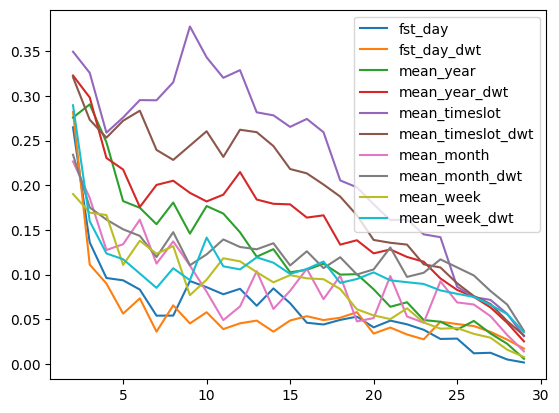

In [32]:
results.plot()